# CV Project - Week 3 Submission

###  Group #1 - Muhammad Hussain Habib (27100016) & Ayaan Ahmed (27100155) 

This notebook demonstrates a Perspective-n-Point (PnP) algorithm to create a multi-view point cloud optimized via Bundle Adjustment

You can find the link to our dataset here: https://drive.google.com/drive/folders/1DVKbLRkWLxdu-5qB_ANK54H9rlfK7fGI?usp=drive_link

<br><br>

In [1]:
import cv2
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.sparse import lil_matrix

FRAMES_DIR = "extracted_frames/"
OUTPUT_DIR = "reconstruction_output"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# using frames 0 to 29
IMAGE_INDICES = list(range(0, 30)) 

# camera hardware specifications from EXIF metadata
FOCAL_LENGTH_MM = 24.0
SENSOR_WIDTH_MM = 36.0

In [2]:
# loads an image by index and returns it with dimensions
def load_image(img_idx):
    path = os.path.join(FRAMES_DIR, f"frame_{img_idx:03d}.jpg")
    img = cv2.imread(path)
    h, w = img.shape[:2]
    return img, w, h

# saves 3D points and colors to a PLY file for visualization
def save_ply(filename, points, colors):
    points = np.array(points)
    colors = np.array(colors)
    
    header = [
        "ply",
        "format ascii 1.0",
        f"element vertex {len(points)}",
        "property float x",
        "property float y",
        "property float z",
        "property uchar red",
        "property uchar green",
        "property uchar blue",
        "end_header"
    ]
    
    with open(filename, 'w') as f:
        f.write('\n'.join(header) + '\n')
        for p, c in zip(points, colors):
            f.write(f"{p[0]:.4f} {p[1]:.4f} {p[2]:.4f} {int(c[0])} {int(c[1])} {int(c[2])}\n")
            
    print(f"Saved point cloud to: {filename}")

In [3]:
# using EXIF metadata, we find the intrinsic matrix K
def get_intrinsic_matrix(image_width, image_height):
    max_dim = max(image_width, image_height)
    fx = (max_dim * FOCAL_LENGTH_MM) / SENSOR_WIDTH_MM
    fy = fx
    cx, cy = image_width / 2.0, image_height / 2.0
    
    K = np.array([[fx, 0, cx],
                  [0, fy, cy],
                  [0,  0,  1]], dtype=np.float64)
    return K

# matching SIFT descriptors using Brute Force Matcher (and also applies Lowe's Ratio Test to filter outliers)
def match_features(desc1, desc2, ratio_thresh=0.75):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

    raw_matches = bf.knnMatch(desc1, desc2, k=2)
    
    good_matches = []
    for m, n in raw_matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
            
    return good_matches

In [4]:
# creating a class to hold the state of the reconstruction (including cameras, points and 2D-3D correspondences)
class ReconstructionMap:
    def __init__(self):
        # 3D Data
        self.points_3d = []           # List of [x, y, z]
        self.point_colors = []        # List of [r, g, b]
        
        # Camera Data
        self.camera_poses = {}        # img_idx -> (R, t)
        self.keypoints = {}           # img_idx -> list of KeyPoints
        self.descriptors = {}         # img_idx -> numpy array of descriptors
        
        # correspondences: img_idx -> { keypoint_index : point_3d_index }
        self.point_correspondences = {}

    def add_camera(self, img_idx, R, t, kps, descs):
        self.camera_poses[img_idx] = (R, t)
        self.keypoints[img_idx] = kps
        self.descriptors[img_idx] = descs
        self.point_correspondences[img_idx] = {}

    def add_point(self, point_3d, color, track_list):
        pt_idx = len(self.points_3d)
        self.points_3d.append(point_3d)
        self.point_colors.append(color)
        
        for (img_idx, kp_idx) in track_list:
            self.point_correspondences[img_idx][kp_idx] = pt_idx
            
    def get_point_count(self):
        return len(self.points_3d)
    
    def get_camera_count(self):
        return len(self.camera_poses)

In [5]:
# Bundle Adjustment refines camera poses and 3D points to minimize reprojection error (we are using Sparse Jacobian to save memory)
def bundle_adjustment(recon_map, K, verbose=True):

    print(f"  > Starting Bundle Adjustment (Cameras: {recon_map.get_camera_count()}, Points: {recon_map.get_point_count()})")
    
    cameras = sorted(recon_map.camera_poses.keys())
    cam_id_map = {cam_id: i for i, cam_id in enumerate(cameras)}

    n_cameras = len(cameras)
    n_points = len(recon_map.points_3d)
    
    x0 = []
    # camera parameters (we skip the first camera in order to keep it fixed at origin)
    for cam_idx in cameras[1:]:
        R, t = recon_map.camera_poses[cam_idx]
        rvec, _ = cv2.Rodrigues(R)
        x0.extend(rvec.flatten())
        x0.extend(t.flatten())

    for pt in recon_map.points_3d:
        x0.extend(pt)
        
    x0 = np.array(x0)

    # collecting observations (cam_opt_idx, point_idx, x, y)
    observations = []
    for cam_idx in cameras:
        for kp_idx, pt_idx in recon_map.point_correspondences[cam_idx].items():
            pt_2d = recon_map.keypoints[cam_idx][kp_idx].pt
            cam_opt_idx = cam_id_map[cam_idx] - 1
            observations.append((cam_opt_idx, pt_idx, pt_2d))

    # residual function
    def fun(params):
        # unpacking cameras
        n_opt_cams = n_cameras - 1
        cam_params = params[:n_opt_cams * 6].reshape((n_opt_cams, 6))
        points = params[n_opt_cams * 6:].reshape((n_points, 3))
        
        residuals = []
        
        # fixed camera 0
        R0, t0 = np.eye(3), np.zeros((3, 1))
        
        for (cam_opt_idx, pt_idx, pt_2d) in observations:
            if cam_opt_idx < 0:
                R, t = R0, t0
            else:
                rvec = cam_params[cam_opt_idx, :3]
                t = cam_params[cam_opt_idx, 3:].reshape(3, 1)
                R, _ = cv2.Rodrigues(rvec)
            
            # then we project
            pt_3d = points[pt_idx]
            pt_cam = R @ pt_3d + t.flatten()
            
            # avoiding division by zero
            z = pt_cam[2]
            if z < 1e-5: z = 1e-5
            proj = (K @ pt_cam) / z
            residuals.extend([proj[0] - pt_2d[0], proj[1] - pt_2d[1]])
            
        return np.array(residuals)

    # building sparsity matrix
    m = len(observations) * 2
    n = len(x0)
    A = lil_matrix((m, n), dtype=int)
    
    for i, (cam_opt_idx, pt_idx, _) in enumerate(observations):
        # point connections
        pt_offset = (n_cameras - 1) * 6 + pt_idx * 3
        A[2*i:2*i+2, pt_offset:pt_offset+3] = 1
        
        # camera connections (if not fixed)
        if cam_opt_idx >= 0:
            cam_offset = cam_opt_idx * 6
            A[2*i:2*i+2, cam_offset:cam_offset+6] = 1

    # then we optimize
    res = least_squares(fun, x0, jac_sparsity=A, verbose=0, x_scale='jac', ftol=1e-3, method='trf')
    
    # and update the map,
    n_opt = n_cameras - 1
    optimized_cams = res.x[:n_opt*6].reshape((n_opt, 6))
    optimized_pts = res.x[n_opt*6:].reshape((n_points, 3))
    
    # cameras
    for i, cam_idx in enumerate(cameras[1:]):
        rvec = optimized_cams[i, :3]
        tvec = optimized_cams[i, 3:]
        R, _ = cv2.Rodrigues(rvec)
        recon_map.camera_poses[cam_idx] = (R, tvec.reshape(3, 1))
        
    # and points
    recon_map.points_3d = optimized_pts.tolist()
    
    print(f"  > BA Complete. Final Cost: {res.cost:.2f}")

In [6]:
# finds matches between new image and existing 3D points (returns Rotation, Translation, and (queryIdx, trainIdx) for inliers)
def solve_pnp(recon_map, new_img_idx, kps, descs, K):
    # for optimization, we check matches against the most recently added camera
    ref_cam_idx = max(recon_map.camera_poses.keys())
    ref_descs = recon_map.descriptors[ref_cam_idx]
    
    matches = match_features(descs, ref_descs)
    
    object_points = []
    image_points = []
    valid_matches = [] # (new_kp_idx, existing_3d_idx)
    
    for m in matches:
        new_idx = m.queryIdx
        ref_idx = m.trainIdx
        
        # checking if the reference keypoint is already part of a 3D point
        if ref_idx in recon_map.point_correspondences[ref_cam_idx]:
            pt3d_idx = recon_map.point_correspondences[ref_cam_idx][ref_idx]
            
            object_points.append(recon_map.points_3d[pt3d_idx])
            image_points.append(kps[new_idx].pt)
            valid_matches.append((new_idx, pt3d_idx))
            
    if len(object_points) < 6:
        return None, None, []

    success, rvec, tvec, inliers = cv2.solvePnPRansac(
        np.array(object_points), 
        np.array(image_points), 
        K, None, 
        reprojectionError=10.0,    # a bit higher than normal because we were working with 4k images
        confidence=0.99
    )
    
    if not success: 
        return None, None, []
    
    R, _ = cv2.Rodrigues(rvec)
    
    # filtering valid_matches by inliers
    pnp_matches = [valid_matches[i[0]] for i in inliers]
    
    return R, tvec, pnp_matches

# triangulates new points between two specific views and adds them to the map
def triangulate_and_add(recon_map, img1_idx, img2_idx, K, img1_color_ref):
    R1, t1 = recon_map.camera_poses[img1_idx]
    R2, t2 = recon_map.camera_poses[img2_idx]
    
    kp1 = recon_map.keypoints[img1_idx]
    kp2 = recon_map.keypoints[img2_idx]
    des1 = recon_map.descriptors[img1_idx]
    des2 = recon_map.descriptors[img2_idx]
    
    matches = match_features(des1, des2)
    
    # filtering out matches that are already in the map
    new_matches = []
    for m in matches:
        # if both keypoints are already mapped then skip
        if (m.queryIdx not in recon_map.point_correspondences[img1_idx] and 
            m.trainIdx not in recon_map.point_correspondences[img2_idx]):
            new_matches.append(m)

    if not new_matches:
        return 0

    P1 = K @ np.hstack((R1, t1))
    P2 = K @ np.hstack((R2, t2))
    
    pts1 = np.float32([kp1[m.queryIdx].pt for m in new_matches]).T
    pts2 = np.float32([kp2[m.trainIdx].pt for m in new_matches]).T
    
    # triangulation
    points_4d = cv2.triangulatePoints(P1, P2, pts1, pts2)
    points_3d = (points_4d[:3] / points_4d[3]).T
    
    count = 0
    for i, pt in enumerate(points_3d):
        # point must be in front of both cameras (checking just as sanity check)
        pt_c1 = R1 @ pt + t1.flatten()
        pt_c2 = R2 @ pt + t2.flatten()
        
        if pt_c1[2] > 0 and pt_c2[2] > 0:
            # getting color from image 1
            u, v = int(pts1[0, i]), int(pts1[1, i])
            if 0 <= v < img1_color_ref.shape[0] and 0 <= u < img1_color_ref.shape[1]:
                color = img1_color_ref[v, u][::-1] # BGR to RGB
            else:
                color = [128, 128, 128]
                
            track = [(img1_idx, new_matches[i].queryIdx), 
                     (img2_idx, new_matches[i].trainIdx)]
            
            recon_map.add_point(pt.tolist(), color, track)
            count += 1
            
    return count

### Phase 1 - Feature Extraction

In [7]:
sift = cv2.SIFT_create(nfeatures=40000)
feature_cache = {}
images_cache = {}

# getting intrinsics
img_temp, w, h = load_image(IMAGE_INDICES[0])
K = get_intrinsic_matrix(w, h)
print(f"Intrinsics Matrix K:\n{K}\n\n")

for idx in IMAGE_INDICES:
    img, w, h = load_image(idx)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kps, descs = sift.detectAndCompute(gray, None)
    
    if kps is None or len(kps) < 100:
        print(f"Warning: Frame {idx} has insufficient features.")
        continue
        
    feature_cache[idx] = (kps, descs)
    images_cache[idx] = img # keeping in memory for color extraction
    print(f"Processed Frame {idx}: {len(kps)} features")
    
print("Feature extraction complete")

Intrinsics Matrix K:
[[2.720e+03 0.000e+00 1.536e+03]
 [0.000e+00 2.720e+03 2.040e+03]
 [0.000e+00 0.000e+00 1.000e+00]]


Processed Frame 0: 40001 features
Processed Frame 1: 40000 features
Processed Frame 2: 40000 features
Processed Frame 3: 40000 features
Processed Frame 4: 40000 features
Processed Frame 5: 40000 features
Processed Frame 6: 40000 features
Processed Frame 7: 40000 features
Processed Frame 8: 40000 features
Processed Frame 9: 40000 features
Processed Frame 10: 40001 features
Processed Frame 11: 40000 features
Processed Frame 12: 40000 features
Processed Frame 13: 40001 features
Processed Frame 14: 40000 features
Processed Frame 15: 40000 features
Processed Frame 16: 40001 features
Processed Frame 17: 40000 features
Processed Frame 18: 40000 features
Processed Frame 19: 40000 features
Processed Frame 20: 40000 features
Processed Frame 21: 40003 features
Processed Frame 22: 40000 features
Processed Frame 23: 40000 features
Processed Frame 24: 40001 features
Processed Fr

### Phase 2 - Map Initialization

In [8]:
recon = ReconstructionMap()

idx1, idx2 = IMAGE_INDICES[0], IMAGE_INDICES[2] # choosing a wide baseline
print(f"Using Frame {idx1} and Frame {idx2}")

kp1, des1 = feature_cache[idx1]
kp2, des2 = feature_cache[idx2]

# step #1 - match
matches = match_features(des1, des2)
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

# step #2 - find essential matrix and camera pose
E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
_, R, t, pose_mask = cv2.recoverPose(E, pts1, pts2, K, mask=mask)

# step #3 - add points
recon.add_camera(idx1, np.eye(3), np.zeros((3,1)), kp1, des1)
recon.add_camera(idx2, R, t, kp2, des2)

# step #4 - triangulate initial points
P1 = K @ np.hstack((np.eye(3), np.zeros((3,1))))
P2 = K @ np.hstack((R, t))

pts1_good = pts1[pose_mask.ravel() > 0]
pts2_good = pts2[pose_mask.ravel() > 0]
points_4d = cv2.triangulatePoints(P1, P2, pts1_good.T, pts2_good.T)
points_3d = (points_4d[:3] / points_4d[3]).T

# adding points to map
valid_mask_indices = np.where(pose_mask.ravel() > 0)[0]
for i, pt3d in enumerate(points_3d):
    if pt3d[2] > 0: # Cheirality check
        match_obj = matches[valid_mask_indices[i]]
        
        # getting color
        u, v = int(pts1_good[i,0]), int(pts1_good[i,1])
        color = images_cache[idx1][v, u][::-1]
        
        track = [(idx1, match_obj.queryIdx), (idx2, match_obj.trainIdx)]
        recon.add_point(pt3d.tolist(), color, track)

print(f"Initialization complete with {recon.get_point_count()} points.")

Using Frame 0 and Frame 2
Initialization complete with 1468 points.


### Phase 3 - Incremental Reconstruction

In [9]:
remaining_images = [i for i in IMAGE_INDICES if i not in recon.camera_poses]

for i, next_idx in enumerate(remaining_images):
    print(f"Registering Frame {next_idx}")
    
    kps, descs = feature_cache[next_idx]
    
    # solving PnP
    R, t, pnp_matches = solve_pnp(recon, next_idx, kps, descs, K)
    
    if R is None:
        print("Failed to localize (PnP failed). Skipping.")
        continue
        
    # adding camera
    recon.add_camera(next_idx, R, t, kps, descs)
    
    # registering PnP inliers (linking new 2D points to existing 3D points)
    for (kp_idx, pt3d_idx) in pnp_matches:
        recon.point_correspondences[next_idx][kp_idx] = pt3d_idx
        
    # triangulating new points
    prev_idx = max([k for k in recon.camera_poses.keys() if k != next_idx])
    new_pts_count = triangulate_and_add(recon, prev_idx, next_idx, K, images_cache[prev_idx])
    
    print(f"Pose: Added {new_pts_count} new points.")
    
    # doing bundle adjustment after every 5 frames
    if i > 0 and i % 5 == 0:
        bundle_adjustment(recon, K)
        
print("\nFinal Global Bundle Adjustment")
bundle_adjustment(recon, K)
print("Reconstruction Finished.")

Registering Frame 1
Pose: Added 6935 new points.
Registering Frame 3
Pose: Added 4981 new points.
Registering Frame 4
Pose: Added 9386 new points.
Registering Frame 5
Pose: Added 6772 new points.
Registering Frame 6
Pose: Added 4745 new points.
Registering Frame 7
Pose: Added 6967 new points.
  > Starting Bundle Adjustment (Cameras: 8, Points: 41254)
  > BA Complete. Final Cost: 19654658.76
Registering Frame 8
Pose: Added 6504 new points.
Registering Frame 9
Pose: Added 7878 new points.
Registering Frame 10
Pose: Added 7175 new points.
Registering Frame 11
Pose: Added 5260 new points.
Registering Frame 12
Pose: Added 8644 new points.
  > Starting Bundle Adjustment (Cameras: 13, Points: 76715)
  > BA Complete. Final Cost: 43304855.70
Registering Frame 13
Pose: Added 7580 new points.
Registering Frame 14
Pose: Added 4367 new points.
Registering Frame 15
Pose: Added 7468 new points.
Registering Frame 16
Pose: Added 5855 new points.
Registering Frame 17
Pose: Added 4993 new points.
  > Sta

### Output and Visualization

Loaded 169511 points.


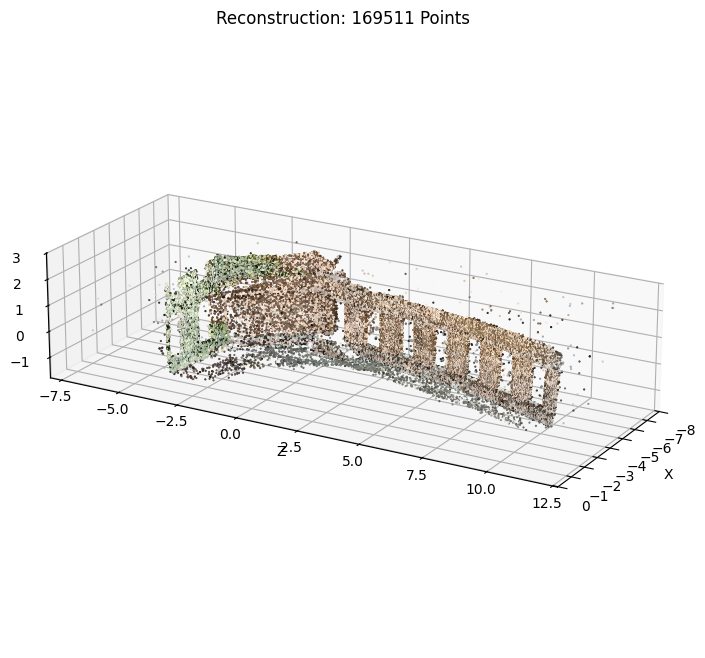

In [ ]:
output_path = os.path.join(OUTPUT_DIR, "final_model.ply")
save_ply(output_path, recon.points_3d, recon.point_colors)

pts = np.array(recon.points_3d)
cols = np.array(recon.point_colors) / 255.0

# filtering outliers for cleaner plot
mean = np.mean(pts, axis=0)
std = np.std(pts, axis=0)
mask = np.all(np.abs(pts - mean) < 2 * std, axis=1)
pts = pts[mask]
cols = cols[mask]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pts[:,0], pts[:,2], pts[:,1], c=cols, s=1.2, marker='.', alpha=1.0)

ax.set_xlabel("X")
ax.set_ylabel("Z")
ax.set_zlabel("Y")
ax.view_init(elev=20, azim=30)
ax.set_title(f"Reconstruction: {len(pts)} Points")
x_range = pts[:,0].max() - pts[:,0].min()
y_range = pts[:,1].max() - pts[:,1].min() 
z_range = pts[:,2].max() - pts[:,2].min()
ax.set_box_aspect((x_range, z_range, y_range))
plt.show()

### Saving Camera Poses for Three.js

In [12]:
def save_ply_manual(filename, points, colors):
    with open(filename, 'w') as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {len(points)}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")
        for p, c in zip(points, colors):
            f.write(f"{p[0]:.4f} {p[1]:.4f} {p[2]:.4f} {int(c[0])} {int(c[1])} {int(c[2])}\n")
    print(f"Saved {filename}")

def export_final_fixed(recon_map, output_json="project_data.json", output_ply="model.ply"):
    
    # OpenCV (Y-Down, Z-Forward) -> Three.js (Y-Up, Z-Backwards)
    M = np.array([
        [1.0,  0.0,  0.0, 0.0],
        [0.0, -1.0,  0.0, 0.0],
        [0.0,  0.0, -1.0, 0.0],
        [0.0,  0.0,  0.0, 1.0]
    ])

    # transforming and exporting cameras
    cameras_json = []
    for img_idx, (R, t) in recon_map.camera_poses.items():
        # constructing OpenCV world matrix (4x4), camera position C = -R^T * t
        R_wc = R.T
        C = -R_wc @ t
        
        T_cv = np.eye(4)
        T_cv[:3, :3] = R_wc
        T_cv[:3, 3] = C.flatten()
        
        # T_new = M * T_old * M
        T_three = M @ T_cv @ M
        
        cameras_json.append({
            "id": img_idx,
            "filename": f"frame_{img_idx:03d}.jpg",
            # Three.js uses Column-Major
            "matrix": T_three.T.flatten().tolist()
        })

    raw_points = np.array(recon_map.points_3d)
    
    # handling colors (ensuring they are 0-255)
    if len(recon_map.point_colors) > 0:
        raw_colors = np.array(recon_map.point_colors)
        if raw_colors.max() <= 1.0:
             raw_colors = raw_colors * 255.0
    else:
        raw_colors = np.ones_like(raw_points) * 255

    # apply M to points (flipping Y and Z)
    # since points are Nx3, we multiply columns 1 and 2 by -1
    aligned_points = raw_points.copy()
    aligned_points[:, 1] *= -1
    aligned_points[:, 2] *= -1
    
    ply_path = os.path.join(OUTPUT_DIR, output_ply)
    json_path = os.path.join(OUTPUT_DIR, output_json)

    save_ply_manual(ply_path, aligned_points, raw_colors)

    data = {
        "cameras": cameras_json,
        "point_cloud_file": output_ply
    }
    with open(json_path, "w") as f:
        json.dump(data, f)
    
    print(f"Done. Exported {len(cameras_json)} cameras and {len(aligned_points)} points.")

export_final_fixed(recon)

Saved reconstruction_output\model.ply
Done. Exported 30 cameras and 169511 points.
